 # Petfinder: Bay Area Dog Adoption
 ![Icon](images/pets.jpg)

### Notebook Contents

------

### Imports

In [1]:
import petpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
dogs = pd.read_csv('./petfinder_data/uncleandogs.csv')

 ______

### Petfinder API + Petpy Wrapper

In [4]:
# Using petpy wrapper with petfinder API keys (removed my personal key + secret)
#pf = petpy.Petfinder(key='your key here', secret='your secret key here')


In [5]:
#dogs = pf.animals(animal_type='dog', status='adopted', results_per_page=100, pages=200, location=94602, 
                   #before_date = '2021-01-01', after_date='2018-12-31', return_df=True)


- petfinder would not allow me to pull two years worth of data at once, so this required pulling the maximum, finding the end date down to the minute, re-inputting that into my pull request before date and running again as dogs2 and finally concatenating those df's as shown below

In [6]:
#dogs.sort_values(by=['published_at'], inplace=True)

In [7]:
dogs.shape

(20000, 49)

In [8]:
dogs.drop(columns=['url', 'photos', 'videos', 'organization_animal_id'])

,id,organization_id,type,species,age,gender,size,coat,tags,name,description,status,status_changed_at,published_at,distance,breeds.primary,breeds.secondary,breeds.mixed,breeds.unknown,colors.primary,colors.secondary,colors.tertiary,attributes.spayed_neutered,attributes.house_trained,attributes.declawed,attributes.special_needs,attributes.shots_current,environment.children,environment.dogs,environment.cats,primary_photo_cropped.small,primary_photo_cropped.medium,primary_photo_cropped.large,primary_photo_cropped.full,contact.email,contact.phone,contact.address.address1,contact.address.address2,contact.address.city,contact.address.state,contact.address.postcode,contact.address.country,animal_id,animal_type,organization_id.1
0,43675837,CA162,Dog,Dog,Baby,Male,Large,Medium,[],Tahoe,Tahoe is a GSD and Bernese Mountain Dog mix. H...,adopted,2019-01-06T04:24:04+0000,2019-01-02T19:56:29+0000,40.1912,German Shepherd Dog,Bernese Mountain Dog,True,False,Black,Sable,White / Cream,True,False,NaN,False,True,NaN,NaN,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,solanospca@gmail.com,(707) 448-7722,2200 Peabody Rd,PO Box 356,Vacaville,CA,95696.0,US,43675837,dog,ca162
1,43675879,CA162,Dog,Dog,Baby,Male,Small,Short,[],Natomas,Natomas is a 16 week old Chihuahua mix and he&...,adopted,2019-01-16T23:13:41+0000,2019-01-02T20:03:38+0000,40.1912,Chihuahua,NaN,True,False,Sable,White / Cream,NaN,True,False,NaN,False,True,NaN,NaN,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,solanospca@gmail.com,(707) 448-7722,2200 Peabody Rd,PO Box 356,Vacaville,CA,95696.0,US,43675879,dog,ca162
2,43675911,CA162,Dog,Dog,Baby,Male,Small,Medium,[],Folsom,Folsom is a male 16 week old Terrier mix (Chih...,adopted,2019-01-12T01:53:52+0000,2019-01-02T20:10:02+0000,40.1912,Terrier,NaN,True,False,Black,Sable,White / Cream,True,False,NaN,False,True,NaN,NaN,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,solanospca@gmail.com,(707) 448-7722,2200 Peabody Rd,PO Box 356,Vacaville,CA,95696.0,US,43675911,dog,ca162
3,43675933,CA162,Dog,Dog,Baby,Female,Small,Short,[],Moraine,Moraine is a female Black/Brown/White Terrier ...,adopted,2019-01-06T04:24:04+0000,2019-01-02T20:15:37+0000,40.1912,Terrier,NaN,True,False,Black,Brown / Chocolate,White / Cream,True,False,NaN,False,True,NaN,NaN,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,solanospca@gmail.com,(707) 448-7722,2200 Peabody Rd,PO Box 356,Vacaville,CA,95696.0,US,43675933,dog,ca162
4,43675957,CA1826,Dog,Dog,Young,Female,Small,Short,"['TINY', 'DARLING', 'FRIENDLY']",WYNNI,WYNNI is a darling and tiny Chi girl who is on...,adopted,2019-01-17T18:18:39+0000,2019-01-02T20:20:36+0000,60.1221,Chihuahua,NaN,False,False,"Tricolor (Brown, Black, & White)",NaN,NaN,True,False,NaN,False,True,NaN,True,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...,kritter.kamp@yahoo.com,916-691-1364,NaN,NaN,Elk Grove,CA,95758.0,US,43675957,dog,ca1826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,50176128,CA2692,Dog,Dog,Baby,Male,Medium,Short,[],Zuko,Zuko is a 6 month old lab/Aussie mix puppy. He...,adopted,2021-01-07T14:53:31+0000,2021-01-01T00:47:56+0000,71.1

In [9]:
#dogs.drop(columns=['primary_photo_cropped'], inplace=True)

In [10]:
#dogs.to_csv('./petfinder_data/uncleandogs.csv', index = False)

In [11]:
# Had to make multiple requests, so concatenating them
#dogs = pd.concat((dogs1, dogs2))

## Feature Engineering

In [12]:
# Renaming some columns for easier readability/coding
dogs.rename(columns={"attributes.spayed_neutered": "fixed", 
                     "attributes.house_trained": "house_trained", 
                     'attributes.special_needs': 'special_needs', 
                      'attributes.shots_current': 'shots_current',
                     'environment.children': 'good_with_kids', 
                     'environment.dogs': 'good_with_dogs', 
                      'environment.cats': 'good_with_cats', 
                     'contact.address.city': 'city', 
                     'contact.address.postcode': 'zipcode' }, inplace=True)

In [13]:
# Making sure all cities match up and no duplicates - combining modesto which appeared in two cases
dogs['city']=dogs['city'].replace('modesto','Modesto')

In [14]:
# Converting videos column to 1 if post has a video, else 0
dogs['videos'] = np.where(dogs['videos']!= '[]', 1, 0)

In [15]:
# Adding a column, 1 if post has photos, else 0
dogs['has_photo'] = np.where(dogs['photos']!= '[]', 1, 0)

In [16]:
# Replacing NA with 2 if the following features are unknown
dogs['good_with_kids'] = dogs['good_with_kids'].fillna(2)
dogs['good_with_dogs'] = dogs['good_with_dogs'].fillna(2)
dogs['good_with_cats'] = dogs['good_with_cats'].fillna(2)

# Converting from boolean to integers
dogs['fixed'] = (dogs['fixed'] * 1).astype(int)
dogs['house_trained'] = (dogs['house_trained'] * 1).astype(int)
dogs['shots_current'] = (dogs['shots_current'] * 1).astype(int)
dogs['good_with_kids'] = (dogs['good_with_kids'] * 1).astype(int)
dogs['good_with_dogs'] = (dogs['good_with_dogs'] * 1).astype(int)
dogs['good_with_cats'] = (dogs['good_with_cats'] * 1).astype(int)
dogs['special_needs'] = (dogs['special_needs'] * 1).astype(int)
dogs['breeds.mixed'] = (dogs['breeds.mixed'] *1).astype(int)

______

### Heatmap

In [17]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(dogs.corr()[['days_on_petfinder']].sort_values(by='days_on_petfinder', ascending=True),
#             vmin = -1, vmax=1,
#             cmap ='winter',
#             annot = True,);
# plt.title("Correlation With Adoption Speed", size = 20);

# # only run when you create target column first - before dummies

### Dummies

In [18]:
# Function to dummify and combine multiclass columns (ie. primary.breed, secondary.breed)
def dummy(df, label):
    cols = [col for col in df if label in col]
    dummy_dict = {}
    main_df = pd.get_dummies(df[cols[0]],prefix = label)
    for col in cols[1:]:
        dummy_dict[col] = pd.get_dummies(df[col],prefix = label)
    for col in dummy_dict:
        main_df = main_df.add(dummy_dict[col], fill_value = 0).gt(0)*1
    return main_df

In [19]:
dogs.shape

(20000, 50)

In [20]:
# Running function for color columns and merging dummified df back to original df

dummy_color_dog = dummy(dogs, 'color') 
dogs = pd.merge(dogs, dummy_color_dog, left_index=True, right_index=True)

In [21]:
# Running function for breed columns and merging dummified df back to original df

dogs.drop(columns=['breeds.unknown'], inplace=True) # All breeds are known or guessed at so dropping this column
dummy_color_dog = dummy(dogs, 'breeds') 
dogs = pd.merge(dogs, dummy_color_dog, left_index=True, right_index=True)

In [22]:
# Dummifying some categorical columns
dogs = pd.get_dummies(dogs, columns=['age', 'gender', 'size', 'coat', 'city', 'zipcode', 
                                     'good_with_kids', 'good_with_dogs', 'good_with_cats'])

In [23]:
# Dropping columns deemed by me to be irrelevant
dogs.drop(columns=['type', 'species', 'url', 'tags', 'organization_animal_id', 'status', 'breeds.primary', 'breeds.secondary', 
                   'colors.primary', 'colors.secondary', 'colors.tertiary', 'attributes.declawed', 'primary_photo_cropped.small', 'primary_photo_cropped.medium',
                   'primary_photo_cropped.large', 'primary_photo_cropped.full', 'contact.email', 'contact.phone', 'contact.address.address1',
                   'contact.address.address2', 'contact.address.country', 'contact.address.state', 'animal_id', 'animal_type', 'organization_id.1']
          , inplace=True)

### Target Column Creation

In [24]:
# Converting columns to datetime
dogs['published_at']= pd.to_datetime(dogs['published_at'])
dogs['status_changed_at']= pd.to_datetime(dogs['status_changed_at'])

In [25]:
# Consructing target from datetime columns
dogs['days_on_petfinder'] = dogs['status_changed_at'] - dogs['published_at']
dogs['days_on_petfinder'] = dogs['days_on_petfinder'] / np.timedelta64(1, 'D')
dogs['days_on_petfinder'] = dogs['days_on_petfinder'].round()

**Dog adopted in under two weeks: 1, over two weeks: 0**

In [26]:
dogs.loc[dogs['days_on_petfinder'] < 14, 'days_on_petfinder'] = 1

In [27]:
dogs.loc[dogs['days_on_petfinder'] >= 14, 'days_on_petfinder'] = 0

In [28]:
# classes decently balanced
dogs.days_on_petfinder.value_counts()

1.0    10634
0.0     9366
Name: days_on_petfinder, dtype: int64

### Sentiment Analysis

In [29]:
# Adding a compound polarity score column
dogs = dogs[dogs['description'].notna()]

desc_list = dogs['description'].tolist()

analyzer = SentimentIntensityAnalyzer()

def get_polarity(desc_list):
    polarity = []
    for post in desc_list:
        vs = analyzer.polarity_scores(post)
        polarity.append(vs['compound']) 
    return polarity

polarity = get_polarity(desc_list)

dogs['polarity'] = polarity

In [30]:
# Adding description length column
dogs['desc_len'] = [len(x) for x in dogs['description']]

### -Finalizing DataFrame

In [31]:
# Creating a list of my categorical columns for later use in modeling
categorical = ['id', 'organization_id', 'name', 'description', 'photos', 'status_changed_at', 'published_at', 'days_on_petfinder']

In [32]:
# Creating a df of numerical columns for later use in modeling
numerical = dogs.drop(categorical, axis=1)

In [33]:
#dogs.to_csv('./petfinder_data/cleandogs.csv', index = False)

----------

### Most Common Words

In [34]:
#dog_list = 

In [35]:
#stop_words = text.ENGLISH_STOP_WORDS.union(dog_list)

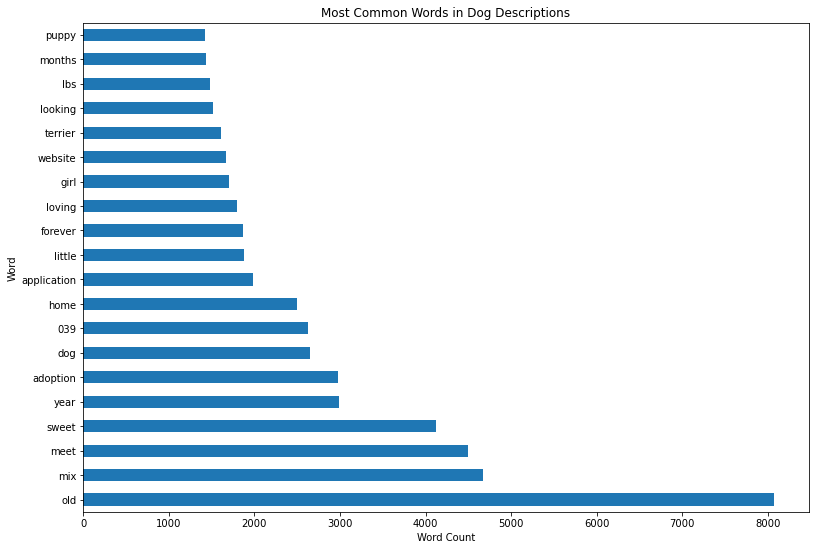

In [36]:
dogs = dogs[dogs['description'].notna()]

dog_cvec= CountVectorizer(stop_words='english')
X = dogs['description']
dog_cvec.fit(X)
X_trans = dog_cvec.transform(X)

X_trans = pd.DataFrame(X_trans.todense(), 
                 columns=dog_cvec.get_feature_names())

plt.figure(figsize = [13, 9])
plt.title('Most Common Words in Dog Descriptions')
plt.xlabel('Word Count')
plt.ylabel('Word')
X_trans.sum().sort_values(ascending = False).head(20).plot(kind='barh');

-------

## Logreg

In [37]:
# Dropping columns from data frame and dummifying categorical columns
X = dogs.drop(columns=categorical)
y = dogs['days_on_petfinder']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42)

In [38]:
%%time
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
lr_train = lr.score(X_train, y_train)
lr_test = lr.score(X_test, y_test)

CPU times: user 1min 28s, sys: 1.36 s, total: 1min 30s
Wall time: 15.6 s


In [39]:
print(f'train score: {lr_train}')
print(f'test score: {lr_test}')

train score: 0.7256352053891777
test score: 0.7176289716433208


In [40]:
# Baseline
dogs['days_on_petfinder'].value_counts(normalize=True)

1.0    0.529394
0.0    0.470606
Name: days_on_petfinder, dtype: float64

In [41]:
y_pred=lr.predict(X_test)
y_pred[0:20]

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1.])

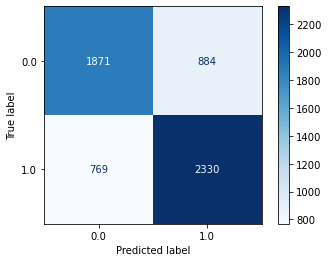

In [42]:
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [44]:
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 1871

False Positives: 884

False Negatives: 769

True Positives: 2330


In [45]:
coef_df = pd.DataFrame({
    'features': X.columns,
    'coef': np.exp(lr.coef_[0]),
})

coef_df.sort_values(by='coef', ascending=False).head()
# As coefficients approach 1 they are more likely to be positive class, as approach 0 more likely to be negative class

,features,coef
506,zipcode_95150.0,16.417346
411,zipcode_94141.0,16.298981
509,zipcode_95155.0,10.122096
449,zipcode_94601.0,9.073319
474,zipcode_94955.0,6.622077


-------

## TFIDF

**Feature Engineering**

In [46]:
# Dropping 489 columns with no description - may replace with none?
#dogs = dogs[dogs['description'].notna()]

In [47]:
dogs['description'].fillna('None', inplace=True)

In [48]:
X = dogs['description']
y = dogs['days_on_petfinder']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42)

In [50]:
tvec = TfidfVectorizer()

In [51]:
# Instantiating a pipeline, and specifying Multinomial Naive Bayes as the estimator, and CountVectorizer as the transformer.
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())])

# Evaluating how my model will perform on unseen data.
print(f'Cross-Val Score   = {cross_val_score(pipe, X_train, y_train, cv = 5).mean()}') 

# Fitting my model.
pipe.fit(X_train, y_train)

# Looking at training and testing scores for my pipeline.
print(f'Training Accuracy = {pipe.score(X_train, y_train)}')
print(f'Testing Accuracy  = {pipe.score(X_test, y_test)}')

# Defining my list of cvec hyperparameters to test in my gridsearch.
pipe_params = {
    # Defining max numbers of features to be fit.
    'tvec__max_features': [5_000, 10_000, 15_000, 20_000, 25_000],
    # Specifying that a token must occur a minumum of 2, 3, or 5 times to be factored into the model.
    'tvec__min_df': [2, 3, 5],
    # Specifying no stop words, English stop words, and my own stop words (defined above).
    'tvec__stop_words': [None, 'english'],
    # Checking individual tokens, and individual tokens and 2-grams.
    'tvec__ngram_range': [(1,1), (1,2), (2,2)]
}

# Instantiating GridSearchCV on my cvec-transformed data.
gs = GridSearchCV(pipe, 
                  param_grid = pipe_params,
                  # 5-fold cross-validation.
                  cv = 5,                   
                  n_jobs = 6) 

Cross-Val Score   = 0.6402585305207334
Training Accuracy = 0.7814307681042689
Testing Accuracy  = 0.6481038606081312


In [52]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=6,
             param_grid={'tvec__max_features': [5000, 10000, 15000, 20000,
                                                25000],
                         'tvec__min_df': [2, 3, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [53]:
# Looking at the best parameters my gridsearch chose for this model.
gs.best_params_

{'tvec__max_features': 25000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [54]:
gs.best_score_

0.6532918505762962